# Deliberable 3: Artistic Style Transfer using VGG
In this jupyter notebook, we present the VGG neural network and its architecture to be used for the transfer of artist's styles.

In this particular delivery, we focus on the setup and first training iterations of our network.

## Import libraries and Images

Tensorflow-Keras libraries.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [0]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


Useful "Digital Image Processing" and "System" libraries.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
from PIL import Image
import time
import os
import functools

## Define useful function
Function for load image and preprocessing with the correct format for visualization.

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

Function to visualize images.

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

Function to load and preprocess image for VGG19 input format. 

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

Function that perform the inverse of preprocess image for visualize output results.

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

Function to load and access the hidden layers for create a model to style transfer.

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

Function that compute content loss of each layer.

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

Function with Gram matrix implement.

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)


Function that compute style loss.

In [0]:
def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

The Function, that feeding with content and style images, gives as a output the feature representation from our model.

In [0]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

Function that compute the loss.

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

Function that compute the gradients.

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

## Main function, Style Transfer.
This function is a optmization loop that is implemented using the functions defined previously.

###Optimization for Different Learning Rates

One of the most important steps in the process is defining the optimization function and its parameters. Most style transfer papers and projects use the "Adams" Optimization for its low error rate, relatively short execution time (at least compared to other optimization functions) and the final results in style transfer, as they are more true to the original artist's style, altering its content to the minimum. The only other contestant, relative to its results, is L-BFGS; however, this function tends to have large loss "jumps" during its firsts iterations and it requires more work to be implemented than Adams' one. The benefits that L-BFGS presents do not outperform Adams' optimization function by an enough margin to be worth the switch.

In [0]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2,
                       learningRate=5): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() #To use VGG19 model.
  for layer in model.layers:
    layer.trainable = False #No layers are trainable (do not modify its values nor its weights).
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path) #Get style from pastiche and content from original image, from specific layers.
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features] #Gram Matrix features and weights.
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learningRate, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  loss_list = []
  style_loss_list = []
  content_loss_list = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss

    loss_list.append(loss)
    style_loss_list.append(style_score)
    content_loss_list.append(content_score)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss, loss_list, style_loss_list, content_loss_list

In [0]:
def plot_loss(total_loss, style_loss, content_loss):
  total_loss = np.array(total_loss)
  style_loss = np.array(style_loss)
  content_loss = np.array(content_loss)
  plt.title('Loss Over Iteration')
  plt.plot(total_loss, 'r', label='total loss')
  plt.plot(style_loss, 'b', label='style loss')
  plt.plot(content_loss, 'g', label='content loss')
  plt.legend()
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.ylim(top=0.1*1e8)
  plt.show()

# Exectution of the code

### Import "Content" and "Style" Images
The style image is the one whose style we want to learn and copy.
The content image is the one we want to apply the style to keeping the content.

In [0]:
from google.colab import files 
files = files.upload() #Browse to import content image.

Saving Diego_Velazquez_51.jpg to Diego_Velazquez_51.jpg
Saving Diego_Velazquez_52.jpg to Diego_Velazquez_52.jpg
Saving Tomas_00.jpg to Tomas_00.jpg


In [0]:
content_path = 'Tomas_00.jpg'
style_path = 'Diego_Velazquez_51.jpg'

### Visualize Content and Style images.

In [0]:
content_img = load_img(content_path) #Read the content image.
style_img = load_img(style_path) #Read the style image.

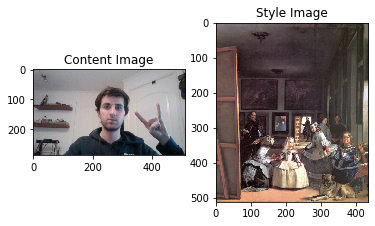

In [0]:
plt.subplot(1,2,1)
imshow(content_img, 'Content Image')
plt.subplot(1,2,2)
imshow(style_img, 'Style Image')
plt.show()

### Selected layer for Content and Style extraction from the network.

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Execution of Style Transfer process.
In the following section, the transfer style can be run for different learning rates, which will result in different results and execution times.

### Learning Rate 0.1

Ellapsed Time for learning rate = 0.1 : 266.402880191803


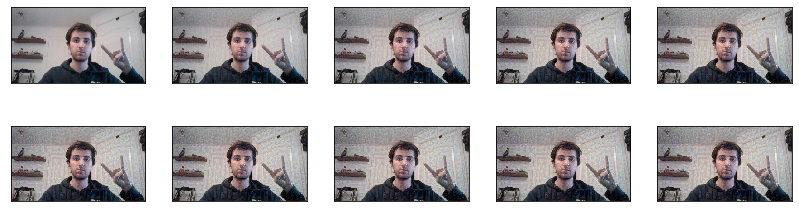

In [0]:
LR = 0.1
ti = time.time()
best, best_loss, total_loss, style_loss, content_loss = run_style_transfer(content_path, style_path, num_iterations=1000, learningRate=LR)
tf = time.time()
print("Ellapsed Time for learning rate =",LR,":",(tf-ti))

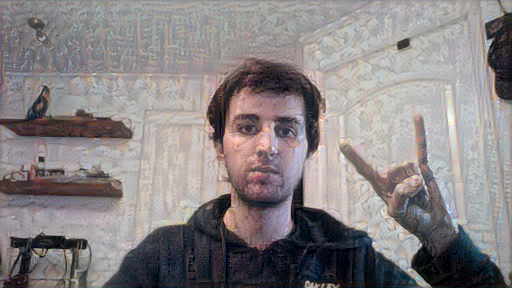

In [0]:
Image.fromarray(best)

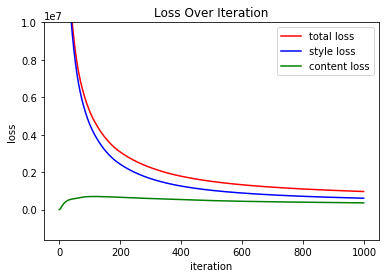

In [0]:
plot_loss(total_loss, style_loss, content_loss)

In [0]:
print('Total Loss: ' + str(np.array(total_loss)[-1]))
print('Style Loss: ' + str(np.array(style_loss)[-1]))
print('Content Loss: ' + str(np.array(content_loss)[-1]))

Total Loss: 963162.1
Style Loss: 605918.8
Content Loss: 357243.3


### Learning Rate 0.2

Ellapsed Time for learning rate = 0.2 : 242.64680576324463


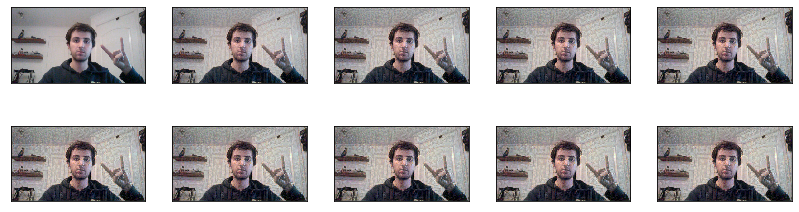

In [0]:
LR = 0.2
ti = time.time()
best, best_loss, total_loss, style_loss, content_loss = run_style_transfer(content_path, style_path, num_iterations=1000, learningRate=LR)
tf = time.time()
print("Ellapsed Time for learning rate =",LR,":",(tf-ti))

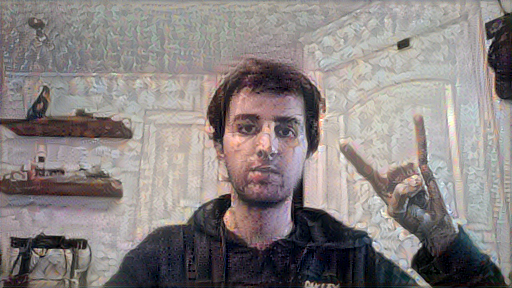

In [0]:
Image.fromarray(best)

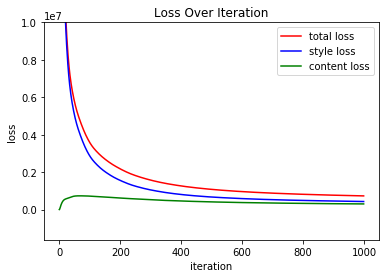

In [0]:
plot_loss(total_loss, style_loss, content_loss)

In [0]:
print('Total Loss: ' + str(np.array(total_loss)[-1]))
print('Style Loss: ' + str(np.array(style_loss)[-1]))
print('Content Loss: ' + str(np.array(content_loss)[-1]))

Total Loss: 729208.6
Style Loss: 428854.34
Content Loss: 300354.28


### Learning Rate 1

Ellapsed Time for learning rate = 1 : 242.20917010307312


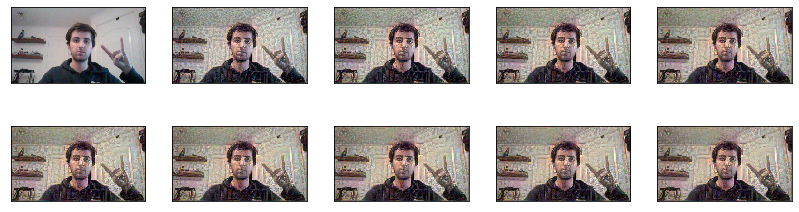

In [0]:
LR = 1
ti = time.time()
best, best_loss, total_loss, style_loss, content_loss = run_style_transfer(content_path, style_path, num_iterations=1000, learningRate=LR)
tf = time.time()
print("Ellapsed Time for learning rate =",LR,":",(tf-ti))

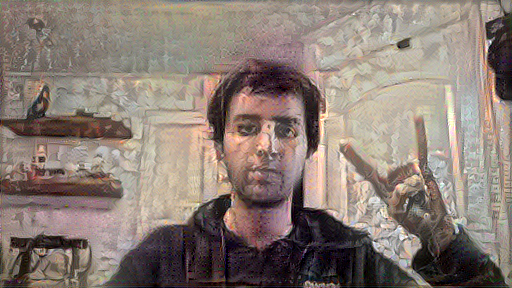

In [0]:
Image.fromarray(best)

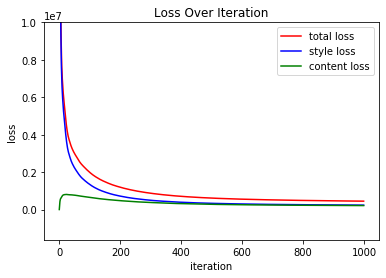

In [0]:
plot_loss(total_loss, style_loss, content_loss)

In [0]:
print('Total Loss: ' + str(np.array(total_loss)[-1]))
print('Style Loss: ' + str(np.array(style_loss)[-1]))
print('Content Loss: ' + str(np.array(content_loss)[-1]))

Total Loss: 448016.9
Style Loss: 235394.17
Content Loss: 212622.73


### Learning Rate 5

Ellapsed Time for learning rate = 5 : 243.53896975517273


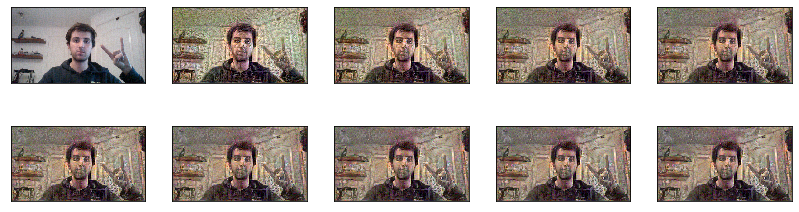

In [0]:
LR = 5
ti = time.time()
best, best_loss, total_loss, style_loss, content_loss = run_style_transfer(content_path, style_path, num_iterations=1000, learningRate=LR)
tf = time.time()
print("Ellapsed Time for learning rate =",LR,":",(tf-ti))

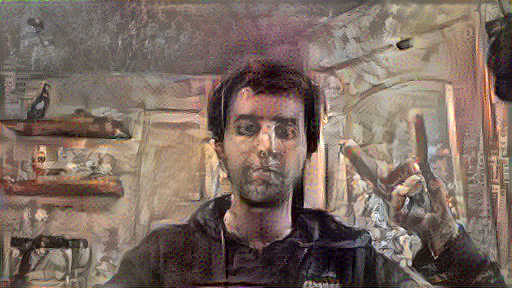

In [0]:
Image.fromarray(best)

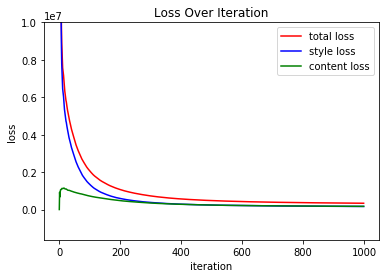

In [0]:
plot_loss(total_loss, style_loss, content_loss)

In [0]:
print('Total Loss: ' + str(np.array(total_loss)[-1]))
print('Style Loss: ' + str(np.array(style_loss)[-1]))
print('Content Loss: ' + str(np.array(content_loss)[-1]))

Total Loss: 336530.38
Style Loss: 165308.06
Content Loss: 171222.31


### Learning Rate 10

Ellapsed Time for learning rate = 10 : 243.19245290756226


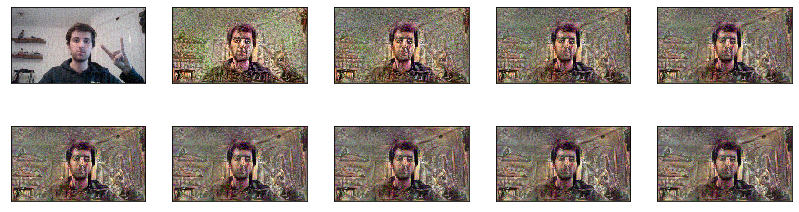

In [0]:
LR = 10
ti = time.time()
best, best_loss, total_loss, style_loss, content_loss = run_style_transfer(content_path, style_path, num_iterations=1000, learningRate=LR)
tf = time.time()
print("Ellapsed Time for learning rate =",LR,":",(tf-ti))

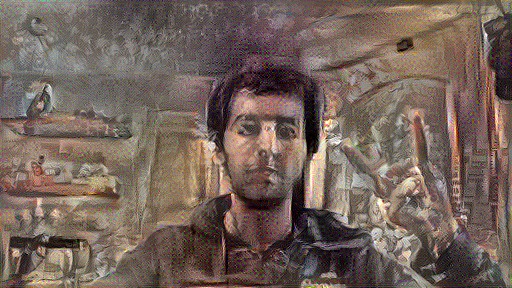

In [0]:
Image.fromarray(best)

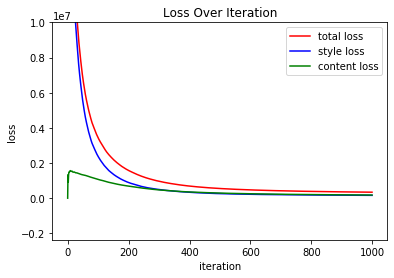

In [0]:
plot_loss(total_loss, style_loss, content_loss)

In [0]:
print('Total Loss: ' + str(np.array(total_loss)[-1]))
print('Style Loss: ' + str(np.array(style_loss)[-1]))
print('Content Loss: ' + str(np.array(content_loss)[-1]))

Total Loss: 340390.3
Style Loss: 161174.42
Content Loss: 179215.89


### Testing

Ellapsed Time for learning rate = 10 : 110.61417531967163


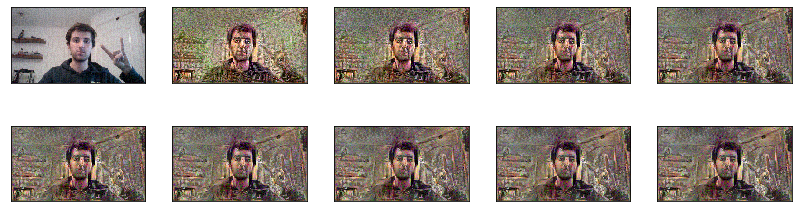

In [0]:
LR = 10
ti = time.time()
best, best_loss, total_loss, style_loss, content_loss = run_style_transfer(content_path, style_path, num_iterations=1000, learningRate=LR)
tf = time.time()
print("Ellapsed Time for learning rate =",LR,":",(tf-ti))

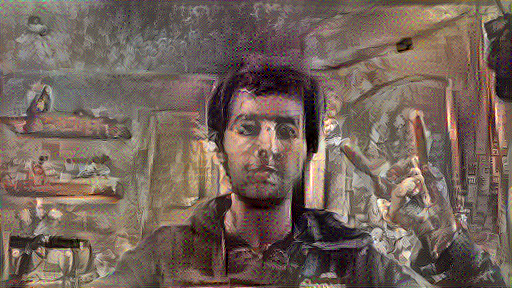

In [0]:
Image.fromarray(best)

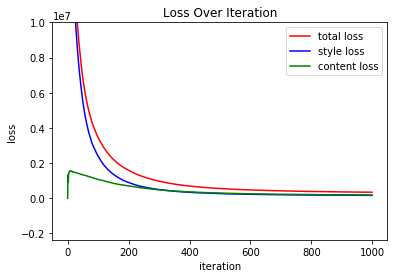

In [0]:
plot_loss(total_loss, style_loss, content_loss)

In [0]:
print('Total Loss: ' + str(np.array(total_loss)[-1]))
print('Style Loss: ' + str(np.array(style_loss)[-1]))
print('Content Loss: ' + str(np.array(content_loss)[-1]))

Total Loss: 338926.34
Style Loss: 159114.6
Content Loss: 179811.75
